#   Differential gene expression analysis

![](./images/Module2/DE_pipeline.jpg)

The next step in the pathway analysis workflow is differential expression (DE)  analysis. The goal of DE testing is to determine which genes are expressed at different levels between two or more biological conditions. These genes can offer biological insight into the processes affected by the condition(s) of interest. DE analysis means taking the normalized read count data and performing statistical analysis to discover quantitative changes in expression levels between experimental groups. For example, we use statistical testing to decide whether, for a given gene, an observed difference in read counts is significant: that is, whether it is greater than what would be expected just due to natural random variation. This learning submodule demonstrates a computational workflow for the detection of DE genes from RNA-Seq data.

## Learning Objectives:
1. Assign samples into groups and set up design matrix.
2. Perform differential expression (DE) analysis using `limma`, `t-test`, `edgeR` and `DEseq` R packages.
3. Filter and export the results table.
4. Further visualization

## Loading the dataset.
In this section we will perform differential expression (DE) analysis to analyze the `GSE48350` dataset that we have used in the previous submodule.
Recall from the [**GEO Data processing** ](./Module01-GEO_Data_Processing.ipynb) section, `GSE48350` contains
sequenced data of Human Alzheimer's Disease using microarray sequencing technology collected from 4 brain regions.
We have already created two groups: *disease* and *control* from the Entorhinal Cortex region. First, we need to load the data that has been saved from submodule 1.

In [1]:
# Loading data from the rds file
data <- readRDS("./data/GSE48350.rds")
expression_data <- data$expression_data
norm_expression_data <- data$norm_expression_data
groups <- data$groups

Now we have all the data needed to perform DE analysis. We will be using 4 different methods to test differential expression: `limma`, t-tests, `edgeR`, and `DESeq2`.

## DE analysis and visualization using limma.
By far, the most-popular package for performing differential expression is `limma`. This packages uses gene-wise linear models and empirical Bayesian statistical methods to calculate differential expression. First we need to install and load the `limma` R package from Bioconductor using
the following command.

In [2]:
suppressMessages({if (!require("BiocManager", quietly = TRUE))
    suppressWarnings(install.packages("BiocManager"))
  suppressWarnings(BiocManager::install("limma", update = T))
})

In [3]:
suppressPackageStartupMessages({
  library("limma")
})

The first step of DE analysis using `limma` is to separate the samples in our dataset to the sample groups of interest. A useful function is `model.matrix`, which will create a design matrix of *0* and *1s*; one row for each sample and one column for each sample group. A *1* in a particular row and column indicates that a given sample (the row) belongs to a given group (column).

In [4]:
groups <- factor(groups$groups)
# Create design matrix with no intercept
design <- model.matrix(~0 + groups)
colnames(design) <- levels(groups)
head(design)

ERROR: Error in `contrasts<-`(`*tmp*`, value = contr.funs[1 + isOF[nn]]): contrasts can be applied only to factors with 2 or more levels


The `lmFit` function is used to fit the model to the data. The result of which is to estimate the expression level in each of the groups that we specified.

In [5]:
fit <- lmFit(norm_expression_data, design)  # fit linear model

ERROR: Error: data object is NULL


In order to perform the *differential analysis*, we have to define the contrast that we are interested in. In our case we only have two groups and one contrast of interest. Multiple contrasts can be defined in the `makeContrasts` function.

In [6]:
# set up contrasts of interest and recalculate model coefficients
cts <- paste("c", "d", sep="-")
cont.matrix <- makeContrasts(contrasts=cts, levels=design)
cont.matrix

ERROR: Error in is.factor(levels): object 'design' not found


Fit the contrast matrix:

In [ ]:
fit2 <- contrasts.fit(fit, cont.matrix)

Finally, apply the *empirical Bayes’* step to get our differential expression statistics and p-values:

In [ ]:
# compute statistics and table of top significant genes
fit2 <- eBayes(fit2, 0.01)

To see the number of significantly up- and down-regulated genes, we can use the code below to generate the summary table.

In [ ]:
dt <- decideTests(fit2,p.value=0.05)
summary(dt)

Here, significance is defined using an adjusted p-value cutoff that is set at 5% by default. For the comparison between expression levels in *“disease”* (d) and *“control”* (c), 293 genes are found to be down-regulated and 489 genes are up-regulated. We also can extract a table of the top-ranked genes from a linear model fit using `topTable` function. By default, `topTable` arranges genes from smallest to largest adjusted p-value with associated gene information, log-FC, average log-CPM, moderated t-statistic, raw and adjusted p-value for each gene. The number of top genes displayed can be specified, where `number=Inf` includes all genes.

In [ ]:
top_genes <- topTable(fit2, adjust="fdr", sort.by="B", number=Inf)

In [ ]:
head(top_genes)

In order to perform pathway and enrichment analyses, we only focus on the genes that are statistically significant and the probe IDs that have gene symbols. We can select those genes using the following command:

In [ ]:
DE_Gene <- top_genes[which(top_genes$adj.P.Val<0.05),]
head(DE_Gene)

Now, we can use the following script to save the DE analysis result to use in the later submodules.


In [15]:
# Add one column to store the probe IDs
top_genes <- tibble::rownames_to_column(top_genes,"PROBEID")
saveRDS(top_genes, file="./data/DE_genes.rds")

```{admonition} Saving data to the Google Cloud Bucket
gsutil cp ./data/DE_genes.rds gs://cpa-output
```

## DE analysis using t-test
A t-test is a simple way to perform DE analysis. This method aims at comparing the means of expression values of two groups for each gene. It is often used in hypothesis testing to determine whether two groups (control versus disease) are different from one another. We can use `row_t_equalvar` available in the `matrixTests` package to perform t-test between the two groups for each gene. Below is the code to install the necessary packages:

In [21]:
suppressMessages({
  suppressWarnings(install.packages("matrixTests",quiet= T))
})
# Load matrixTests package
suppressPackageStartupMessages({library("matrixTests")})

First we need to create two different expression matrices belong to two groups.

In [22]:
# Assign expression matrix to the count
count <- expression_data
# Divide the count matrix into two separate matrices X and Y. X is control group and Y is the disease group
X <- count[,groups=="c"]
Y <- count[,groups=="d"]

In [23]:
# Perform t-test
res <- row_t_equalvar(X,Y,alternative = "two.sided", mu = 0, conf.level = 0.95)

The output is a table where rows are genes and columns are statistical information of the test. In DE analysis, we only care for the genes that are significantly different. Therefore, we will rank the genes based on *p-value* and remove insignificant genes.

In [24]:
# Order the results based on the p-value
res <- res[order(res$pvalue),]
# Remove insignificant genes
res <- res[res$pvalue<0.05,]
# Show the result of top genes
head(res)

,obs.x,obs.y,obs.tot,mean.x,mean.y,mean.diff,var.x,var.y,var.pooled,stderr,df,statistic,pvalue,conf.low,conf.high,alternative,mean.null,conf.level
,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
222178_s_at,39,15,54,0.1819268,0.6117714,-0.4298446,9.737616e-05,0.0006820712,0.0002547941,0.004849686,52,-88.63350,2.040469e-58,-0.4395762,-0.4201130,two.sided,0,0.95
207488_at,39,15,54,0.4270298,0.8854517,-0.4584219,9.008167e-04,0.0023830695,0.0012998848,0.010953966,52,-41.84985,1.012965e-41,-0.4804026,-0.4364411,two.sided,0,0.95
234109_x_at,39,15,54,0.6103878,0.8874354,-0.2770476,6.857523e-04,0.0012171635,0.0008288245,0.008746821,52,-31.67409,1.151538e-35,-0.2945994,-0.2594958,two.sided,0,0.95
239226_at,39,15,54,1.7324948,1.0013784,0.7311164,1.243088e-02,0.0014187732,0.0094660800,0.029559973,52,24.73332,2.009417e-30,0.6718000,0.7904328,two.sided,0,0.95
216530_at,39,15,54,0.8361470,0.5620650,0.2740821,1.299243e-03,0.0021199336,0.0015201978,0.011845926,52,23.13724,4.856399e-29,0.2503115,0.2978526,two.sided,0,0.95
216490_x_at,39,15,54,1.0243812,0.4847202,0.5396610,8.683469e-03,0.0025726176,0.0070382400,0.025488894,52,21.17240,3.173331e-27,0.4885138,0.5908082,two.sided,0,0.95


To see how many genes left, we can use the following command

In [18]:
dim(res)

[1] 9286   18

In [25]:
# Saving the result to local folder
write.csv(res, file="./data/t-Test_Results.csv")
saveRDS(res, file="./data/t-Test_Results.rds")

```{admonition} Saving data to the Google Cloud Bucket
gsutil cp ./data/t-Test_Results.csv gs://cpa-output


gsutil cp ./data/t-Test_Results.rds gs://cpa-output
```

## DE analysis using edgeR

`edgeR` also uses an empirical Bayes model similar to `limma`. However, instead of using gene-wise linear models, `edgeR` uses an overdispersed Poisson model before implementing the Bayes model to calculate significant differential expression. Many `edgeR` functions are similar to `limma`. 

In [26]:
# Install edgeR package from Bioconductor
suppressMessages({ if (!require("BiocManager", quietly = TRUE))
  install.packages("BiocManager")
  suppressWarnings(BiocManager::install("edgeR", update = F))
})


The downloaded binary packages are in
	/var/folders/xf/v88ngt8s37b5qqxtsz3hwyhm0000gn/T//Rtmp4FdRNF/downloaded_packages


In [27]:
# Load edgeR package
suppressPackageStartupMessages({library("edgeR")})

In [28]:
# Assigning expression matrix to count
count <- expression_data

In [29]:
# Perform DE analysis using DGEList function
dge <- DGEList(counts = count, group = factor(groups))
# Calculating the normalize factor
dge <- calcNormFactors(object = dge)
dge <- estimateDisp(y = dge)
# Perform Fisher-exact test
et <- exactTest(object = dge)
# Getting top DE genes
top_degs = topTags(object = et, n = "Inf")

Using classic mode.



In [30]:
head(top_degs$table)

,logFC,logCPM,PValue,FDR
,<dbl>,<dbl>,<dbl>,<dbl>
224687_at,4.904976,8.019088,4.463490e-158,2.440413e-153
212833_at,3.363579,6.860991,1.652705e-51,4.518082e-47
1558620_at,2.841310,6.619830,2.269510e-37,4.136182e-33
211318_s_at,-2.788104,7.033454,6.724743e-22,9.191883e-18
206552_s_at,3.236385,7.042412,1.493408e-15,1.633042e-11
1553191_at,1.158600,6.798425,1.489697e-06,1.357487e-02


In [31]:
# Saving the result to local folder
write.csv(et$table, file="./data/edgeR_Results.csv")
saveRDS(et$table, file="./data/edgeR_Results.rds")

Terminal Command to save to Google Cloud Bucket

```{admonition} Saving data to the Google Cloud Bucket
gsutil cp ./data/edgeR_Results.csv gs://cpa-output


gsutil cp ./data/edgeR_Results.rds gs://cpa-output
```

## DE analysis using DESeq2
`DeSeq2` uses negative binomial generalized linear models for each gene and a geometric mean strategy to normalize the data. `DESeq2` is similar to `edgeR` as it also assumes that no genes are differentially expressed.

In [32]:
# Installing and loading the library
suppressMessages({ if (!require("BiocManager", quietly = TRUE))
  install.packages("BiocManager")
  suppressWarnings(BiocManager::install("DESeq2", update = F))
})
suppressPackageStartupMessages({library("DESeq2")})


The downloaded binary packages are in
	/var/folders/xf/v88ngt8s37b5qqxtsz3hwyhm0000gn/T//Rtmp4FdRNF/downloaded_packages


In [33]:
# Contructing a group table that has information of group members for all patients.
coldata <- data.frame(
  sample = colnames(expression_data),
  condition = as.factor(groups),
  row.names = "sample" )

In [34]:
# Checking the group information of few first patients
head(coldata)

,condition
,<fct>
GSM300173,c
GSM300177,c
GSM300181,c
GSM300186,c
GSM300189,c
GSM300192,c


In [35]:
# Perform DE analysis using DESeqDataSetFromMatrix function
suppressMessages({
  dds <- DESeqDataSetFromMatrix(countData = round(count), colData = coldata,
                              design = ~ condition)
  dds <- dds[rowSums(counts(dds)) >= 10,]
  dds$condition <- relevel(dds$condition, ref = "c")
  dds <- DESeq(dds)
  resultsNames(dds)
  res <- results(dds)
  res <- as.data.frame(res[order(res$padj),])
})

In [36]:
head(res)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
224687_at,11.590865,5.089289,0.2647166,19.225425,2.267719e-82,1.154087e-77
212833_at,4.138384,3.430013,0.2842036,12.068861,1.542553e-33,3.925180e-29
1558620_at,3.162742,2.979229,0.2892637,10.299352,7.093774e-25,1.203388e-20
206552_s_at,4.890227,3.353613,0.4815026,6.964891,3.286586e-12,4.181523e-08
211318_s_at,4.936976,-2.681179,0.3982190,-6.732928,1.662829e-11,1.692494e-07
1553191_at,3.876015,1.176570,0.2596787,4.530866,5.874235e-06,4.982526e-02


In [37]:
# Saving the result to local storage
write.csv(res, file="./data/DESeq2_Results.csv")
saveRDS(res, file="./data/DESeq2_Results.rds")

```{admonition} Saving data to the Google Cloud Bucket
gsutil cp ./data/DESeq2_Results.csv gs://cpa-output

gsutil cp ./data/DESeq2_Results.rds gs://cpa-output
```

## Visualization of of differential expression results.
To visually summarize results for all genes, mean-difference plots, which display log-fold changes from the linear model fit against the average log-CPM values can be generated using the `plotMD` function in `limma` package, with the differentially expressed genes highlighted. The function `plotMD` uses `fit2` object generated from DE analysis using `limma` in the above section.

In [3]:
plotMD(fit2, column=1, status=dt[,1], main=colnames(fit2)[1],
       xlim=c(-8,13),pch=20, cex=1)
abline(h=0)

ERROR: Error in plotMD(fit2, column = 1, status = dt[, 1], main = colnames(fit2)[1], : could not find function "plotMD"


Another way to visualize the number of regulated and unregulated genes is to use Venn diagram. The command to generate the diagram is presented below

In [7]:
# summarize test results as "up", "down" or "not expressed"
dT <- decideTests(fit2, adjust.method="fdr", p.value=0.05)
# Venn diagram of results
vennDiagram(dT, circle.col=palette())

ERROR: Error in decideTests(fit2, adjust.method = "fdr", p.value = 0.05): object 'fit2' not found


We can visualize the adjusted p-value distribution for all gene using a histogram plot:

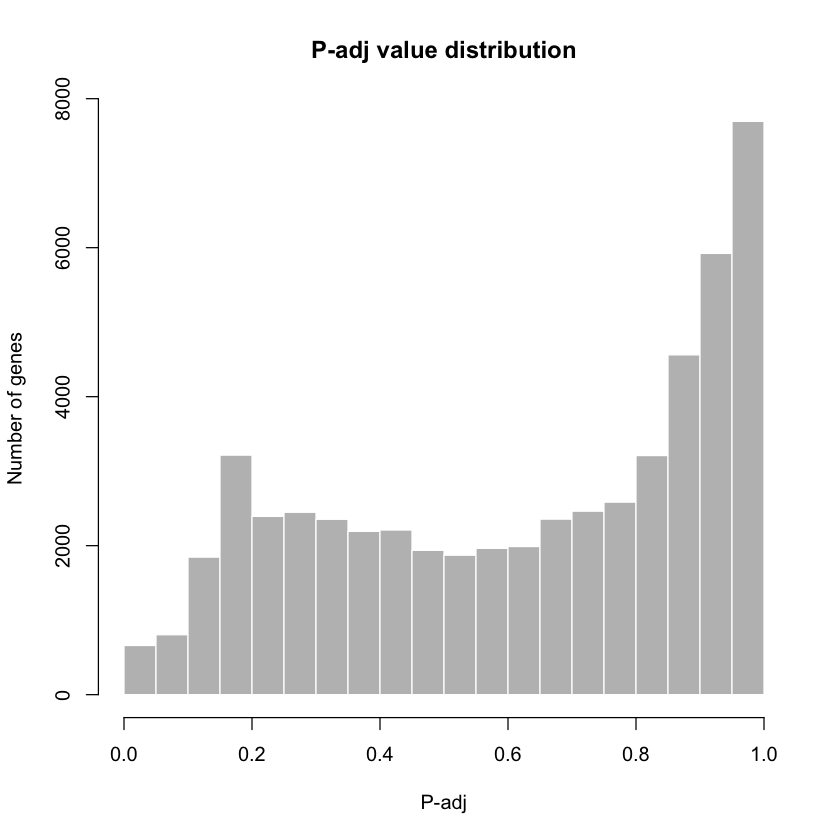

In [42]:
# Visualize and quality control test results.
# Build histogram of P-values for all genes. Normal test
# assumption is that most genes are not differentially expressed.
tT2 <- topTable(fit2, adjust="fdr", sort.by="B", number=Inf)
hist(tT2$adj.P.Val, col = "grey", border = "white", xlab = "P-adj",
     ylab = "Number of genes", main = "P-adj value distribution")

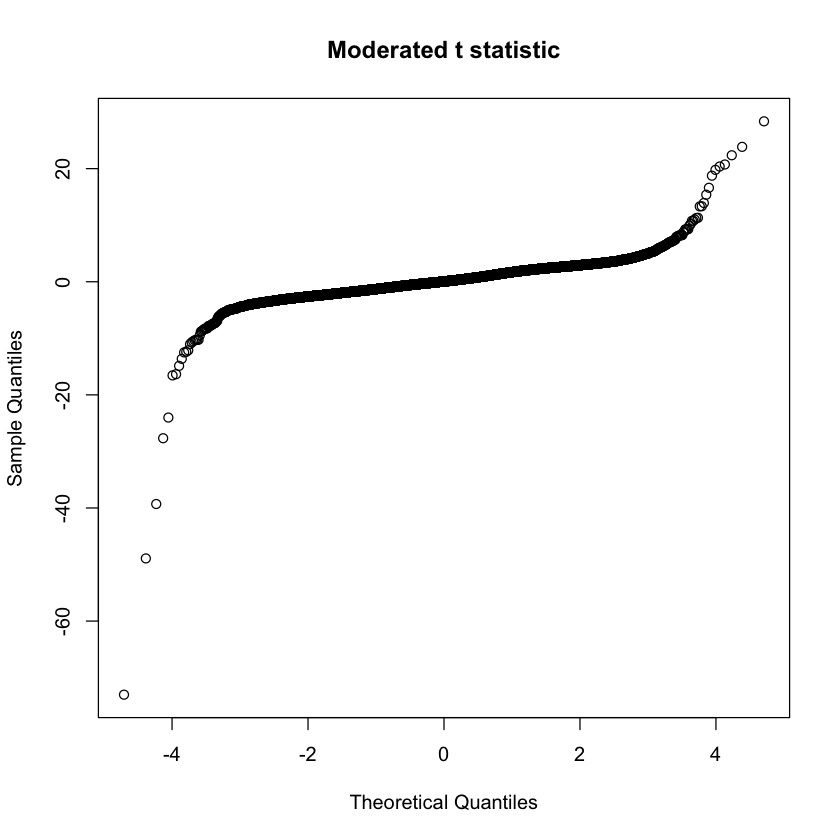

In [43]:
# create Q-Q plot for t-statistic
t.good <- which(!is.na(fit2$F)) # filter out bad probes
qqt(fit2$t[t.good], fit2$df.total[t.good], main="Moderated t statistic")

The *Volcano Plot* function is a common way of visualising the results of a DE analysis. The *x* axis shows the *log-fold* change and the *y* axis is some measure of statistical significance, which in this case is the log-odds, or “B” statistic. A characteristic “volcano” shape should be seen.

[1] "c-d"

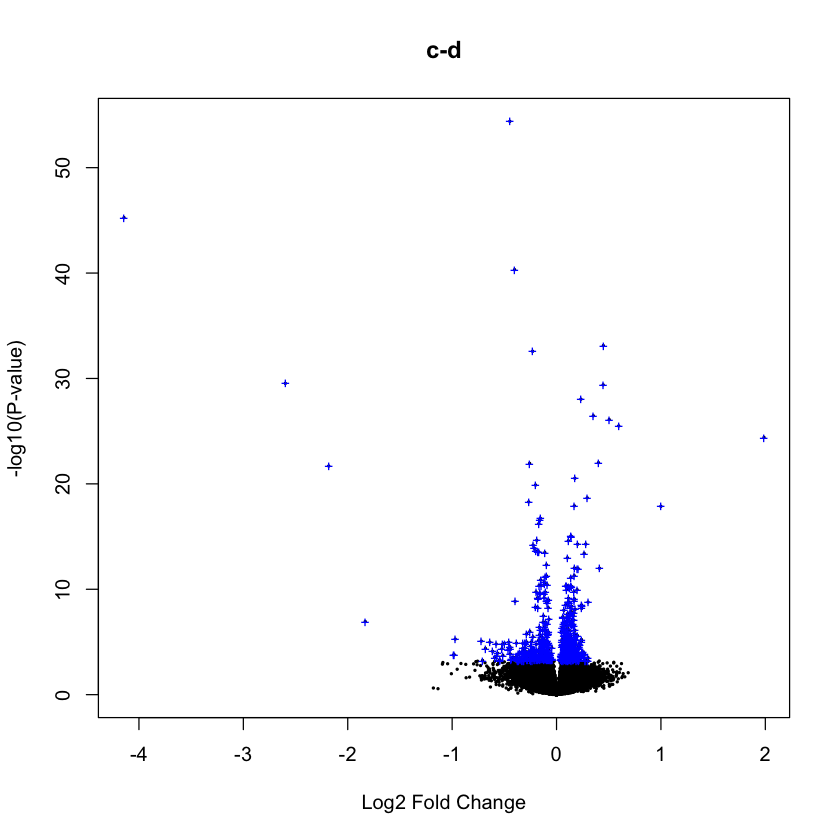

In [44]:
# volcano plot (log P-value vs log fold change)
colnames(fit2) # list contrast names
ct <- 1        # choose contrast of interest
volcanoplot(fit2, coef=ct, main=colnames(fit2)[ct], pch=20,
            highlight=length(which(dT[,ct]!=0)), names=rep('+', nrow(fit2)))


In [1]:
IRdisplay::display_html('<iframe src="Quizzes/Quiz_Submodule2.html" width=100% height=450></iframe>')

The next submodule will show how to identify the pathways that these genes are involved in. 